# Forecasting revenue of a product with Monte-Carlo simulation

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 20 12:09:39 2015

Simulates a market forecast based on current assumptions and set of probabili-
ties for development.

@author: arcosdid
"""
import numpy as np
from pylab import triangular, zeros, percentile
from scipy.stats import binom
import pandas as pd
import seaborn as sns
sns.set_palette('Paired')
sns.set_style("whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

### Define the initial assumptions

In [2]:
#%% Assumptions

# initial market size assumption (total number of potential users)
marketsize_min = 5000
marketsize_mode = 12000
marketsize_max = 15000

marketshare_init = triangular(.003, .005, .01) # min, mode, max
# initial percentage of users that use the product

price_min=500 # minimum product price
price_mode=1000 # mode product price
price_max=1500 # maximum product price

num_timesteps=10 # number of years for the simulation
num_simulations=1024 # number of simulations per year
perc_selection = [5, 25, 50, 75, 95] # percentiles to visualize in plots

### Define the functions to calculate market share and revenue of a product

In [3]:
#%% Functions

def calc_marketshare(marketsize, marketshare):
    '''
    Calculates product market share for a given year as percentage of users
    that use the product compared to total number of users
    
    Arguments:
    marketsize : total market size as number of potential users
    marketshare: observed/assumed percentage of users that use the product
    '''    
    share = binom.rvs(marketsize, marketshare, size=1) / marketsize    
    return share

def calc_revenue(marketsize, marketshare):
    '''
    Calculates the revenue development over a number of years
    
    Arguments:
    marketsize: total market size as number of potential users
    marketshare : observed/assumed percentarge of users that use the product
    '''    
    product_price = triangular(price_min, price_mode, price_max)
    volume = marketsize*marketshare
    revenue = product_price * volume
    return revenue

### Define functions to return logistic and sigmoid distributions

In [4]:
def logist(x, loc, scale, factor):
    '''
    Logistic distribution
    Args:
    x : variable in x-axis, e.g. time
    loc : the mean of the distribution, maximum probability
    scale : steepness of the curve, higher -> steeper
    factor : multiplies to obtain higher probabilities overall
    '''
    return factor*np.exp((loc-x)/scale)/(scale*(1+np.exp((loc-x)/scale))**2)

def sigmoid(x):
    L, q, loc = 10, 1, 3
    return L/(1+np.exp(-q*(x-loc)))

### Data collection and simulation

In [5]:
#%% Empty matrixes for data collection

u = zeros((num_simulations,), dtype=float) 
# temporary market size matrix as number of potential users
s = zeros((num_simulations,), dtype=float) # temporary market share matrix
r = zeros((num_simulations,), dtype=float) # temporary revenue matrix

rev = zeros((num_timesteps, num_simulations), dtype=float) 
# revenue data collection by year
percentiles_rev = zeros((num_timesteps,len(perc_selection)), dtype=float) 
# percentiles_rev data collection by year

usr = zeros((num_timesteps, num_simulations), dtype=float) 
# users data collection by year
percentiles_usr = zeros((num_timesteps,len(perc_selection)), dtype=float) 
# percentiles for total users

sha = zeros((num_timesteps, num_simulations), dtype=float) 
# market share data collection by year
percentiles_sha = zeros((num_timesteps,len(perc_selection)), dtype=float) 
# percentiles for market share

In [6]:
#%% Simulation

for t in range(0, num_timesteps):
    
    if t==0: # First year starting with initial assumptions
        for k in range(num_simulations):
            u[k] = triangular(marketsize_min,marketsize_mode,marketsize_max) 
            # triangular distribution of current number of potential users
            s[k] = calc_marketshare(u[k], marketshare_init) 
            # market share for product
            r[k] = calc_revenue(u[k], s[k]) # revenue
        # store values in first row of matrices:
        rev[t,:] += r
        usr[t,:] += u
        sha[t,:] = s
        #percentiles of the complete revenue row at time t        
        percentiles_rev[t,:] = percentile(rev[t,:], perc_selection)
        percentiles_usr[t,:] = percentile(usr[t,:], perc_selection)
        percentiles_sha[t,:] = percentile(sha[t,:], perc_selection)
        
    else: # Following years starting with the previous year's data
        for k in range(num_simulations):
            # estimate how much the market has grown:
            loc = triangular(1, 2, 4)
            scale = triangular(1, 2, 3)
            factor = 3
            marketgrowth = logist(t, loc, scale, factor)
            u[k] += u[k] * marketgrowth # apply market growth
            s[k] = calc_marketshare(u[k], s[k]) + logist(t, 4, 5, 1) 
            # apply market share increase
            r[k] = calc_revenue(u[k], s[k]) # calculate revenue
        # store values in following rows of matrices
        rev[t,:] = rev[t-1,:] + r
        usr[t,:] += u
        sha[t,:] = s
        #percentiles of the complete revenue row at time t
        percentiles_rev[t,:] = percentile(rev[t,:], perc_selection)
        percentiles_usr[t,:] = percentile(usr[t,:], perc_selection)
        percentiles_sha[t,:] = percentile(sha[t,:], perc_selection)

## Revenue simulation plots

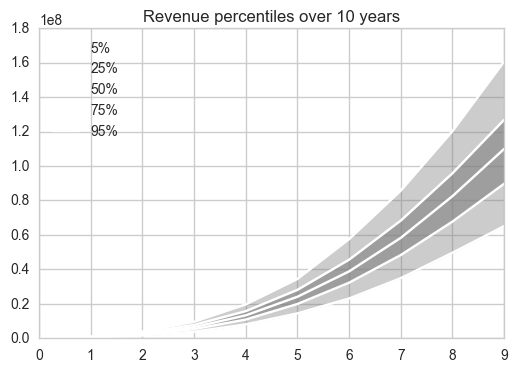

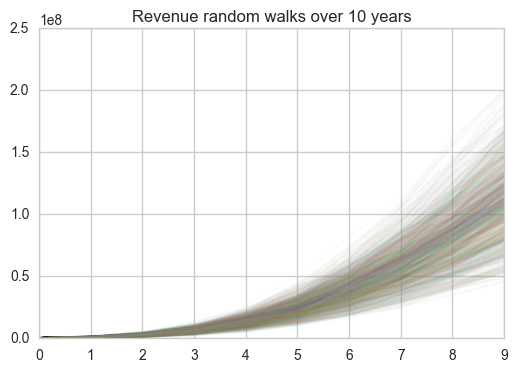

In [7]:
#%% Plots

# Print the percentiles of revenue
df = pd.DataFrame(percentiles_rev, columns=['5%','25%','50%','75%','95%'])
#print(df)

# Plot the percentiles of revenue
x = np.arange(0,10)
df.plot(kind='line', color='w')
plt.fill_between(x,df['25%'].values,df['75%'].values, color='grey', alpha=0.6)
plt.fill_between(x,df['5%'].values,df['95%'].values, color='grey', alpha=0.4)
plt.title("Revenue percentiles over %s years" %num_timesteps)
plt.show()

# Plot the random walks for revenue
df2=pd.DataFrame(rev)
df2.plot(kind='line', legend=False, alpha=.03)
plt.title("Revenue random walks over %s years" %num_timesteps)
plt.show()

## Market share simulation plots

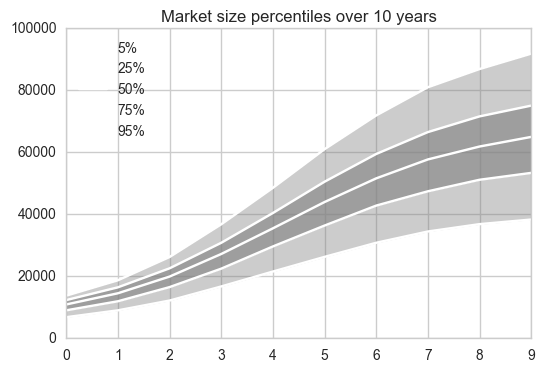

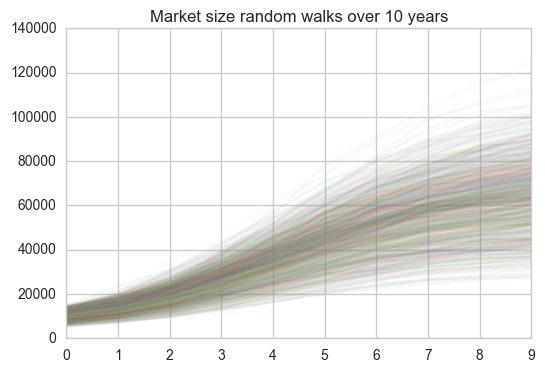

In [8]:
# Print the percentiles of market size
df_usr = pd.DataFrame(percentiles_usr, columns=['5%','25%','50%','75%','95%'])
#print(df)

# Plot the percentiles market size
x = np.arange(0,10)
df_usr.plot(kind='line', color='w')
plt.fill_between(x,df_usr['25%'].values,df_usr['75%'].values, color='grey', alpha=0.6)
plt.fill_between(x,df_usr['5%'].values,df_usr['95%'].values, color='grey', alpha=0.4)
plt.title("Market size percentiles over %s years" %num_timesteps)
plt.show()

# Plot the random walks for market size
df2=pd.DataFrame(usr)
df2.plot(kind='line', legend=False, alpha=.03)
plt.title("Market size random walks over %s years" %num_timesteps)
plt.show()

## Print the percentiles of market share
#df_sha = pd.DataFrame(percentiles_sha, columns=['5%','25%','50%','75%','95%'])
##print(df)
#
## Plot the percentiles of market share
#x = np.arange(0,10)
#df_sha.plot(kind='line', color='w')
#plt.fill_between(x,df_sha['25%'].values,df_sha['75%'].values, color='grey', alpha=0.6)
#plt.fill_between(x,df_sha['5%'].values,df_sha['95%'].values, color='grey', alpha=0.4)
#plt.title("Product market share percentiles over %s years" %num_timesteps)
#plt.show()
#
## Plot the random walks for market share
#df3=pd.DataFrame(sha)
#df3.plot(kind='line', legend=False, alpha=.03)
#plt.title("Product market share random walks over %s years" %num_timesteps)
#plt.show()

## Product revenue distribution

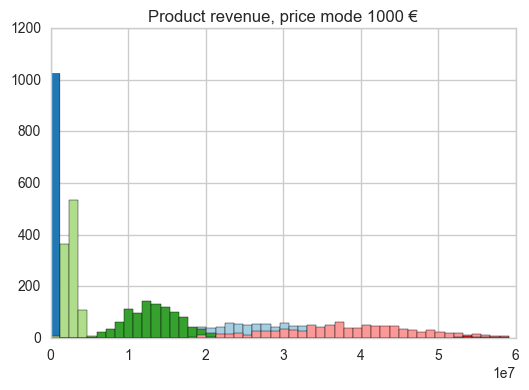

In [9]:
#%%
ax1 = plt.subplot(111)
ax1
#width = 4e12
#height=50*N/1024
plt.title("Product revenue, price mode %s €" %price_mode)
plt.hist(r, bins=50, range=(0, r.max()), )
plt.hist(rev[0], bins=50, range=(0, r.max()), )
plt.hist(rev[2], bins=50, range=(0, r.max()), )
plt.hist(rev[4], bins=50, range=(0, r.max()), )
plt.hist(rev[6], bins=50, range=(0, r.max()), )
plt.hist(rev[9], bins=50, range=(0, r.max()), )#axis([0,width,0,height])
plt.show()

## Market size distribution

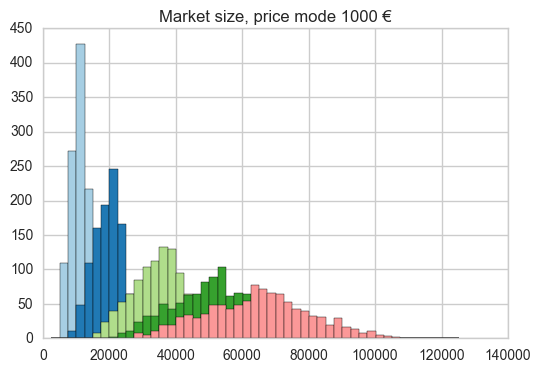

In [10]:
ax2 = plt.subplot(111)
ax2
plt.title("Market size, price mode %s €" %price_mode)
#hist(c, bins=50, range=(0, c.max()), )
plt.hist(usr[0], bins=50, range=(0, u.max()), )
plt.hist(usr[2], bins=50, range=(0, u.max()), )
plt.hist(usr[4], bins=50, range=(0, u.max()), )
plt.hist(usr[6], bins=50, range=(0, u.max()), )
plt.hist(usr[9], bins=50, range=(0, u.max()), )
plt.show()

### Draft test of logistic distribution shape

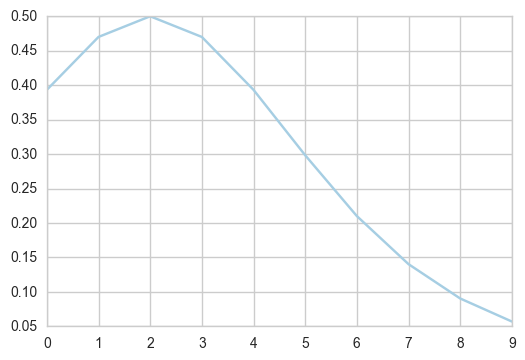

In [11]:
#%%
def logist_test(x, loc, scale):
    loc, scale = 2, 2
    return 4*np.exp((loc-x)/scale)/(scale*(1+np.exp((loc-x)/scale))**2)

plt.plot(logist_test(x, loc, scale))
#plt.plot(bins, logist(bins, loc, scale)*count.max()/logist(bins, loc, scale).max())
plt.show()